In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
# Add the fourier_learning_ibm package to the path
# This is necessary only when running the notebook in the docker container
import sys, pprint

sys.path.append("/home/jovyan/fourier_learning_ibm/")
pprint.pprint(sys.path)

# This is necessary only when running the notebook in the docker container
%cd fourier_learning_ibm/

['/home/jovyan',
 '/opt/conda/lib/python311.zip',
 '/opt/conda/lib/python3.11',
 '/opt/conda/lib/python3.11/lib-dynload',
 '',
 '/opt/conda/lib/python3.11/site-packages',
 '/home/jovyan/fourier_learning_ibm/']
/home/jovyan/fourier_learning_ibm


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import networkx as nx
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    SamplerV2 as Sampler,
    Batch,
)
from heisenberg import (
    HeisenbergModel,
    get_graph,
    get_positions,
)
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit.quantum_info.operators import Operator
from qiskit.primitives import BackendSamplerV2
from qiskit.quantum_info import Statevector, state_fidelity
import json

In [4]:
import warnings

warnings.filterwarnings("ignore")

## $n_{\text{step}}$ の決定

2 量子ビットゲートによる fidelity 減少レートにより導出する。具体的には以下のような手順で求める。

1. 回路で生じるエラーは、(SPAM エラーを除けば) 2 量子ビットゲートが支配的であると仮定し、2 量子ビットゲートの個数を数える。実行時はコンパイルされるので、これより少なくなることに注意 (あくまでもここで求めているのは上限)

(下図は $n=8, n_{\text{step}}=1$ の場合)
![hoge](./img/counting_2qubit_gates.jpg)

**GHZ 部分** :

$\text{GHZ}$ と $\text{GHZ}^{\dagger}$ の左右 2 個あるので、
\begin{align*}
\left( \frac{n}{2}-1\right) \times2=n-2
\end{align*}

**$e^{-iHt}$ 部分** :

2 次のトロッターの場合は $H_{\text{odd}}$ が $n_{\text{step}}+1$ 個ある。各 $H_{\text{odd}}=H_{1,2}+H_{3,4}+\cdots H_{n-3, n-2}$ の項数は、 $\frac{n}{2}-1$.

2 次のトロッターの場合は $H_{\text{even}}$ が $n_{\text{step}}$ 個ある。各 $H_{\text{even}}=H_{0,1}+H_{2,3}+\cdots H_{n-2, n-1}$ の項数は、 $\frac{n}{2}.$

各 $e^{-iH_{i, i+1}t}$ には、2 個の CNOT が含まれるので、CNOT の個数は
\begin{align*}
2\times\left\{\underbrace{\left(\frac{n}{2}-1\right)(n_{\text{step}}+1)}_{H_{\text{odd}}}+\underbrace{\frac{n}{2}\cdot n_{\text{step}}}_{H_{\text{even}}}\right\} = 2n n_{\text{step}} + n -2n_{\text{step}}-2
\end{align*}

GHZ 部分と $e^{-iHt}$ 部分を合わせて、回路全体の CNOT の個数は
\begin{align*}
(n-2)+2n n_{\text{step}} + n -2n_{\text{step}}-2 = 2\left\{(n-1)(n_{\text{step}}+1)-1\right\}
\end{align*}
以下では、この回路をコンパイルした後の CZ ゲートも同程度の個数であると仮定する。


2. 次に、次に、2 量子ビットゲートのエラー率を求める。これは [IBM の公式サイト](https://quantum.ibm.com/)に CZ の中央値が掲載されており、2025 年 1 月 15 日現在、およそ $\epsilon=0.22$% である。

3. 以上より、 $n_{\text{step}}$ step の回路全体の fidelity は
\begin{align*}
(1-\epsilon)^{2\left\{(n-1)(n_{\text{step}})-1\right\}}.
\end{align*}

上の式より、閾値を例えば fidelity 0.80 以上と決めれば、適切な $n_{\text{step}}$ が求められる。

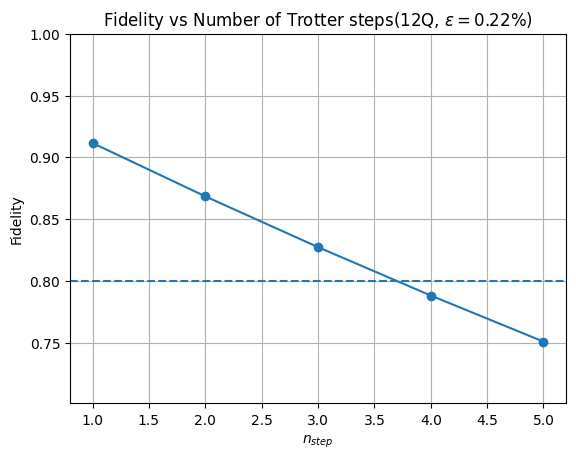

n_step just before reaching the threshold(0.80): 3
We use this n_step=3 for the simulation.


In [5]:
n_qubits = 12
epsilon = 0.0022
threshold = 0.80
min_n_step_to_check = (
    5  # 閾値をチェックする最小の n_step. グラフの見栄えを綺麗にするために設定
)
fidelities = []
n_step_counter = 1
flag_threshold = False  # 閾値に達したかどうかのフラグ

while True:
    fidelity = (1 - epsilon) ** (2 * ((n_qubits - 1) * (n_step_counter + 1) - 1))
    fidelities.append(fidelity)
    # print(f"n_step: {n_step}, fidelity: {fidelity}")

    # 閾値に達した場合、その直前の n_counter を n_step とする
    if fidelity < threshold and flag_threshold == False:
        n_step = n_step_counter - 1
        flag_threshold = True

    # 閾値に達したとしても、min_n_step_to_check に達していない場合は、そのまま続行
    if fidelity < threshold and n_step_counter >= min_n_step_to_check:
        break
    n_step_counter += 1

plt.plot(range(1, len(fidelities) + 1), fidelities, marker="o")
plt.xlabel(r"$n_{step}$")
plt.ylabel("Fidelity")
plt.grid()
plt.axhline(y=threshold, linestyle="dashed")
plt.ylim(min(fidelities) - 0.05, 1)
plt.title(
    rf"Fidelity vs Number of Trotter steps({n_qubits}Q, $\epsilon={epsilon * 100}$%)"
)
plt.savefig(f"results/get_param/{n_qubits}Q_fidelity_vs_nstep.pdf")
plt.show()

print(f"n_step just before reaching the threshold({threshold:.2f}): {n_step}")
print(rf"We use this n_step={n_step} for the simulation.")

## シミュレートする最大時間 $t_K$ (特徴量 $K$) の決定

上のようにして求めた $n_{\text{step}}$ を使い、ランダムに複数個作ったハミルトニアンについてトロッターシミュレーションを行う。その後、複数ハミルトニアンについての平均 fidelity が閾値 xx 以上となる最大の $t$ を $t_K$ とする。

### Check graph (i.e., Heisenberg Hamiltonian)

今回用いるハイゼンベルクモデルを networkx のグラフとして表す。

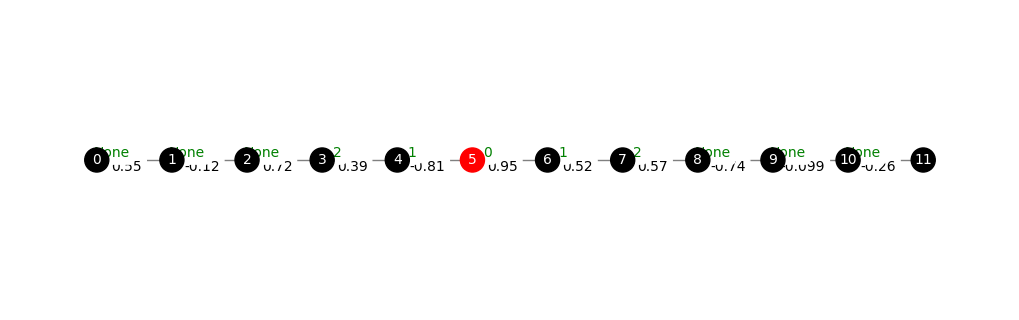

In [6]:
rng = np.random.default_rng(42)
Js = rng.uniform(-1, 1, size=n_qubits - 1)

G = get_graph(n_qubits, Js)
positions = get_positions(n_qubits)

# エッジラベルを作成
edge_J_labels = {edge: f"{G.edges[edge]['J']:.2g}" for edge in G.edges}
edge_cnot_order_labels = {edge: f"{G.edges[edge]['cnot']['order']}" for edge in G.edges}

# グラフを描画
plt.figure(figsize=(10, 3))
nx.draw(
    G,
    pos=positions,
    with_labels=True,
    node_color=["red" if G.nodes[node]["hadamard"] else "black" for node in G.nodes],
    node_size=300,
    edge_color="gray",
    font_color="white",
    font_size=10,
)

# エッジの重みを描画
nx.draw_networkx_edge_labels(
    G,
    pos=positions,
    edge_labels=edge_J_labels,
    font_size=10,
    font_color="black",
    label_pos=0.6,
    verticalalignment="top",
)

# エッジの 'cnot' 'order' 属性を描画
nx.draw_networkx_edge_labels(
    G,
    pos=positions,
    edge_labels=edge_cnot_order_labels,
    font_size=10,
    font_color="green",
    label_pos=0.8,
    verticalalignment="bottom",
)

plt.show()

上の図で、
- 丸はスピンを表し、量子回路を実行するときには量子ビットとしてマップされる
- 赤い丸は、GHZ 部分の最初にアダマールゲートが作用する量子ビットである
- エッジの緑の数字は、GHZ 部分で CNOT が作用する順番である。効率的にエンタングルメントが広がるように、アダマールゲートが作用した量子ゲートから順に CNOT をかけていく。GHZ 部分で用意したい状態は $\ket{00111100}$ (中心半分が 1) なので、CNOT が作用する量子ビットは中心の半分である。'None' はそれ以外、つまり CNOT が作用されず、0 のままであることを表す
- エッジの黒の数字は、相互作用強度 $J_{ij}$ を表す。「ランダムなハミルトニアンを作る」とは、これらの $J_{ij}$ をランダムに作ることを意味する。

### Backend の設定

In [7]:
# Option1: Use IBM Quantum backend.

# Set up the Qiskit Runtime service (this is a one-time setup)
# QiskitRuntimeService.save_account(
#     token="YOUR_API_TOKEN",
#     channel="ibm_quantum",
# )

# Load saved credentials
service = QiskitRuntimeService()
# backend_qpu = service.least_busy(simulator=False, interactional=True)
backend_qpu = service.backend("ibm_marrakesh")
print(f"Using backend QPU: {backend_qpu}")

# Option2: Use local AerSimulator as the backend.
backend_sim = AerSimulator()
noise_model = NoiseModel.from_backend(backend_qpu)
backend_sim_noisy = AerSimulator(noise_model=noise_model)
# Note: statevector simulator
# backend_sim_noisy = AerSimulator(method="statevector", noise_model=noise_model)
print(f"Using backend simulator: {backend_sim}")
print(f"Using backend noisy simulator: {backend_sim_noisy}")

Using backend QPU: <IBMBackend('ibm_marrakesh')>
Using backend simulator: AerSimulator('aer_simulator')
Using backend noisy simulator: AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['id', 'cz', 'sx', 'x', 'measure', 'reset']>)


In [8]:
n_samples = 10
rng = np.random.default_rng(42)

# total time to be simulated
# type of times is list so that it can be saved to json
total_time = 15
times = np.linspace(0, total_time, total_time * 2 + 1).tolist()  # 2 points per second
fidelities: dict[int, list[float]] = {
    # int: sample id
    # list[float]: fidelity for each time
}

for i in range(n_samples):
    fidelities[i] = []
    # Create random Heisenberg Hamiltonian
    Js = rng.uniform(-1, 1, size=n_qubits - 1)
    G = get_graph(n_qubits, Js)
    heisenberg = HeisenbergModel(n_qubits, G)

    for t in times:
        # Exact simulation (Non-Trotter)
        state_exact = heisenberg.exact_simulation(t, phase=0)

        # Trotter simulation
        circuit, exec_circuit = heisenberg.get_trotter_simulation_circuit(
            t, n_step, phase=0
        )
        # Remove final measurements and save statevector
        exec_circuit.remove_final_measurements()
        exec_circuit.save_statevector()
        # Run the circuit
        result_trotter = backend_sim_noisy.run(exec_circuit).result()
        state_trotter = result_trotter.get_statevector()

        # Calculate fidelity
        fidelity = state_fidelity(state_exact, state_trotter)
        if fidelity >= 1:
            fidelity = 1
        elif fidelity <= 0:
            fidelity = 0

        fidelities[i].append(fidelity)
        print(f"sample {i}, time {t}, fidelity {fidelity}")

sample 0, time 0.0, fidelity 0.9999999999999996
sample 0, time 0.5, fidelity 0.9999273004496363
sample 0, time 1.0, fidelity 0.9987248830399632
sample 0, time 1.5, fidelity 0.9884642947860274
sample 0, time 2.0, fidelity 0.9399630275510478
sample 0, time 2.5, fidelity 0.800615494792243
sample 0, time 3.0, fidelity 0.5107426665733916
sample 0, time 3.5, fidelity 0.27012806647223614
sample 0, time 4.0, fidelity 0.28341751754707756
sample 0, time 4.5, fidelity 0.3419591457449131
sample 0, time 5.0, fidelity 0.22975631913153563
sample 0, time 5.5, fidelity 0.20518078514940458
sample 0, time 6.0, fidelity 0.18443702559666292
sample 0, time 6.5, fidelity 0.14640949476943
sample 0, time 7.0, fidelity 0.16329829079992478
sample 0, time 7.5, fidelity 0.2429619816882069
sample 0, time 8.0, fidelity 0.20250257786741574
sample 0, time 8.5, fidelity 0.24800809083364736
sample 0, time 9.0, fidelity 0.30143572114543016
sample 0, time 9.5, fidelity 0.24205340753127544
sample 0, time 10.0, fidelity 0.2

In [9]:
# fidelity の平均と標準偏差を計算
fidelities_mean = np.mean(list(fidelities.values()), axis=0)
fidelities_std = np.std(list(fidelities.values()), axis=0)

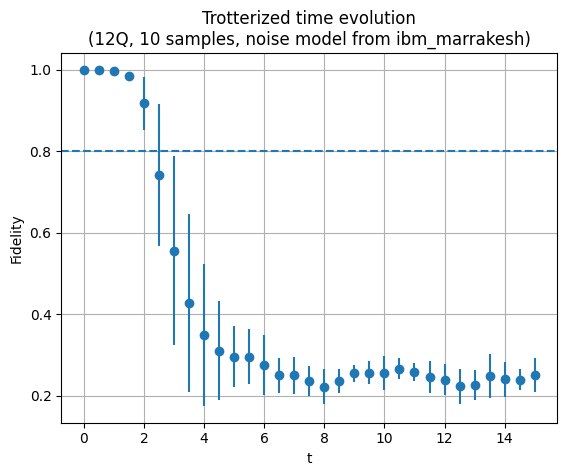

time just before reaching the threshold(0.80): 2.0
We use this t_K=2.0 for the simulation.


In [10]:
# Plot
plt.errorbar(times, fidelities_mean, yerr=fidelities_std, fmt="o")
plt.axhline(y=threshold, linestyle="dashed")
plt.xlabel("t")
plt.ylabel("Fidelity")
plt.grid()
plt.title(
    f"Trotterized time evolution\n({n_qubits}Q, {n_samples} samples, noise model from {backend_qpu.name})"
)
plt.savefig(f"results/get_param/{n_qubits}Q_trotterized_time_evolution.pdf")
plt.show()

# 閾値に達する直前の時間を取得
t_K = times[np.where(fidelities_mean < threshold)[0][0] - 1]
print(f"time just before reaching the threshold({threshold:.2f}): {t_K}")
print(rf"We use this t_K={t_K} for the simulation.")

# Save results to json
with open(f"results/get_param/{n_qubits}Q_get_param_results.json", "w") as f:
    json.dump(
        {
            "n_qubits": n_qubits,
            "n_samples": n_samples,
            "times": times,
            "fidelities": fidelities,
            "fidelities_mean": fidelities_mean.tolist(),
            "fidelities_std": fidelities_std.tolist(),
            "threshold": threshold,
            "t_K": t_K,
        },
        f,
        indent=4,
    )